## Variational AutoEncoder - Part 1

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
reshape=True # Only for GAN for encoder it is different boolean

In [3]:
# Normalizing the values to be between 0 and 1 since the values are in gray scales 
# in between 0 and 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
# Reshape the training and testing data to be as an one dimensional array
if reshape:
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


### VAE Network Parameters

In [6]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 50

### VAE: -> Encoder - from image to the latent parameters, decoder, reparametrization trick

In [7]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0826 17:08:02.741019 140519322158912 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 17:08:02.756031 140519322158912 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 17:08:02.757414 140519322158912 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [8]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [9]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [10]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [11]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [12]:
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [13]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [14]:
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

### Loss is calculated using reconstruction loss and KL divergence term

In [15]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='adam', loss=total_loss)

W0826 17:08:05.302093 140519322158912 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 17:08:05.324820 140519322158912 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0826 17:08:05.330888 140519322158912 deprecation.py:323] From /home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [17]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [18]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
decode_intermediate (Dense)  (None, 512)               1536      
_________________________________________________________________
decode_full (Dense)          (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [19]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [20]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0826 17:08:07.331907 140519322158912 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 172us/step - loss: 200.7394 - val_loss: 175.5761
Epoch 2/50
60000/60000 [==============================] - 10s 167us/step - loss: 168.8863 - val_loss: 165.9338
Epoch 3/50
60000/60000 [==============================] - 9s 150us/step - loss: 163.4672 - val_loss: 161.9301
Epoch 4/50
60000/60000 [==============================] - 9s 149us/step - loss: 161.2229 - val_loss: 160.6020
Epoch 5/50
60000/60000 [==============================] - 9s 154us/step - loss: 159.3692 - val_loss: 158.7158
Epoch 6/50
60000/60000 [==============================] - 12s 194us/step - loss: 157.8537 - val_loss: 157.3891
Epoch 7/50
60000/60000 [==============================] - 10s 167us/step - loss: 156.6040 - val_loss: 156.1780
Epoch 8/50
60000/60000 [==============================] - 10s 170us/step - loss: 155.2946 - val_loss: 155.6407
Epoch 9/50
60000/60000 [==============================] - 10s 164

In [21]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [22]:
x_test_encoded.shape

(10000, 2)

In [23]:
x_test_encoded[:10]

array([[ 3.541923  ,  1.4403663 ],
       [-0.05272776, -0.37761635],
       [-0.8221169 ,  4.6346803 ],
       [-1.452375  , -2.1592307 ],
       [ 1.5383122 , -1.1216427 ],
       [-0.8994334 ,  3.3850853 ],
       [ 1.1796793 ,  0.0647133 ],
       [ 1.011882  , -0.96193576],
       [ 0.03453985,  0.37930316],
       [ 1.5292733 ,  0.7441828 ]], dtype=float32)

### Generating the new digits

In [24]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

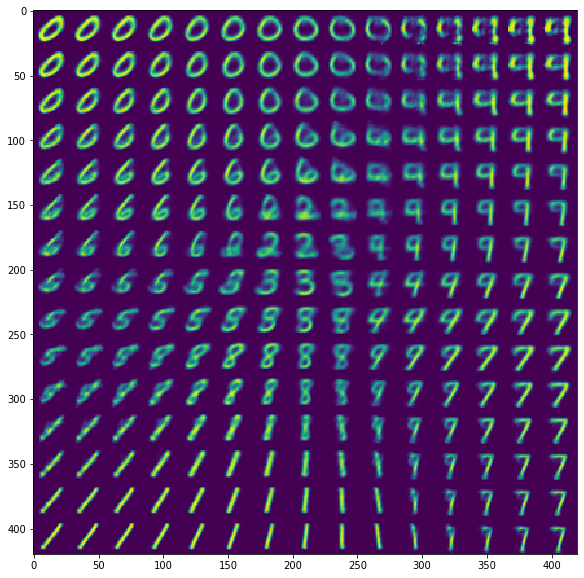

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Latent space - centroids, sampling strategies - linear, spherical, lagrange, riemannian metric

### 1. centroids

In [26]:
## Making centroids for each of the cluster
centroids = dict()
unique_labels = np.unique(y_test)
for i in unique_labels:
    cluster_indices = np.where(y_test == i)[0]
    cluster_points = x_test_encoded[cluster_indices]
    
    # Calculate the median not the mean since it ignores outliers 
    # and find the centroid based on the distribution of the points
    median_one = np.median(cluster_points[:, 0])
    median_two = np.median(cluster_points[:, 1])
    centroids[median_one] = median_two
    
print(centroids)

{-1.0906289: -2.5095735, -0.2974857: 3.0329745, -0.21289614: -0.48930416, -0.10073306: 0.0579109, 1.3152547: -0.1526477, -0.22497244: 0.3222931, -0.86549544: -1.1311724, 2.5733705: 0.8032485, -0.07449624: 0.7145057, 1.6246653: -0.09483287}


In [27]:
# need to convert it into list - because dict_keys and dict_values - code smell!
centroids_keys = list(centroids.keys())
centroids_vals = list(centroids.values())

In [28]:
def generate_images_interp(x_vals, y_vals, n=10):
    ## Helper function: to generate images based on values
    ## of X and Y generated from the interpolation function
    # display a 2D manifold of the digits
    digit_size = 28 # Size of the digits
    interp_figure = np.zeros((digit_size * n, digit_size))
    cnt = 0

    for i in zip(x_vals, y_vals):
        xi, yi = i[0], i[1]
        z_val = np.array([[xi, yi]])
        x_decoded = generator.predict(z_val)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        interp_figure[cnt * digit_size: (cnt + 1) * digit_size] = digit
        cnt += 1
    
    plt.figure(figsize=(10, 10))
    plt.imshow(interp_figure)
    plt.show()

In [29]:
## Linear Interpolation
## Written by myself but will use SCIPY later.
## Lets do it between centroids 7 and 9
t = 20
x_1 = centroids_keys[7]
x_2 = centroids_keys[2]
y_1 = centroids_vals[7]
y_2 = centroids_vals[2]
fixed_t_x_vals = np.linspace(x_1, x_2, t)
fixed_t_y_vals = []
for x_n in fixed_t_x_vals:
    y_n = y_1 + ((y_2 - y_1)/(x_2 - x_1)) * (x_n - x_1)
    fixed_t_y_vals.append(y_n)

In [30]:
## Spherical Interpolation - use same value of t as above since it is global
## Much better
angle_param = np.linspace(0, 1, 20)
start_vector = np.array([x_1, y_1])
end_vector = np.array([x_2, y_2])
# Normalizing the vector since SLERP works on that
start_vector_norm = start_vector / np.sqrt(np.sum(start_vector ** 2))
end_vector_norm = end_vector / np.sqrt(np.sum(end_vector ** 2))
# To check how close they are or not, if they are too close - linear interpolation would do.
dot_of_vectors = np.dot(start_vector_norm, end_vector_norm)
# clipped_vector = np.clip(dot_of_vectors, -1, 1) # to put in the range of cos and sin, otherwise it might give some issues
# Finding the angle theta0 between original vectors 
theta_0 = np.arccos(dot_of_vectors)
sin_theta_0 = np.sin(theta_0)
theta = theta_0 * angle_param
sin_theta = np.sin(theta)
# # Finding the orthogonal vector to the start vector so that we can apply the orthogonality principle
s0 = np.cos(theta) - dot_of_vectors * sin_theta / sin_theta_0
s1 = sin_theta / sin_theta_0
slerped_result = (s0[:,np.newaxis] * start_vector[np.newaxis,:]) + (s1[:,np.newaxis] * end_vector[np.newaxis,:])

In [31]:
slerped_result

array([[ 2.57337046,  0.80324852],
       [ 2.78786538,  0.8031716 ],
       [ 2.96213148,  0.79150493],
       [ 3.0936541 ,  0.76841686],
       [ 3.18053536,  0.73424056],
       [ 3.22152159,  0.68946918],
       [ 3.21602134,  0.63474878],
       [ 3.16411398,  0.57086898],
       [ 3.06654854,  0.49875154],
       [ 2.92473289,  0.41943714],
       [ 2.74071341,  0.33407027],
       [ 2.51714551,  0.24388277],
       [ 2.25725526,  0.15017606],
       [ 1.96479288,  0.0543023 ],
       [ 1.64397859, -0.04235504],
       [ 1.29944173, -0.13840119],
       [ 0.93615396, -0.23245022],
       [ 0.55935751, -0.32314499],
       [ 0.17448954, -0.4091768 ],
       [-0.2128963 , -0.48930419]])

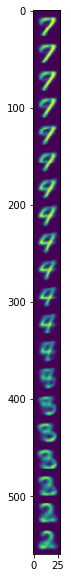

In [32]:
## Results for linear interpolation
generate_images_interp(fixed_t_x_vals, fixed_t_y_vals, n=20)

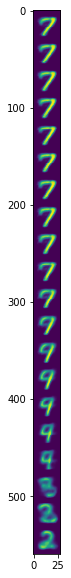

In [33]:
## Results for Spherical Interpolation
generate_images_interp(slerped_result[:,0], slerped_result[:,1], n=20)

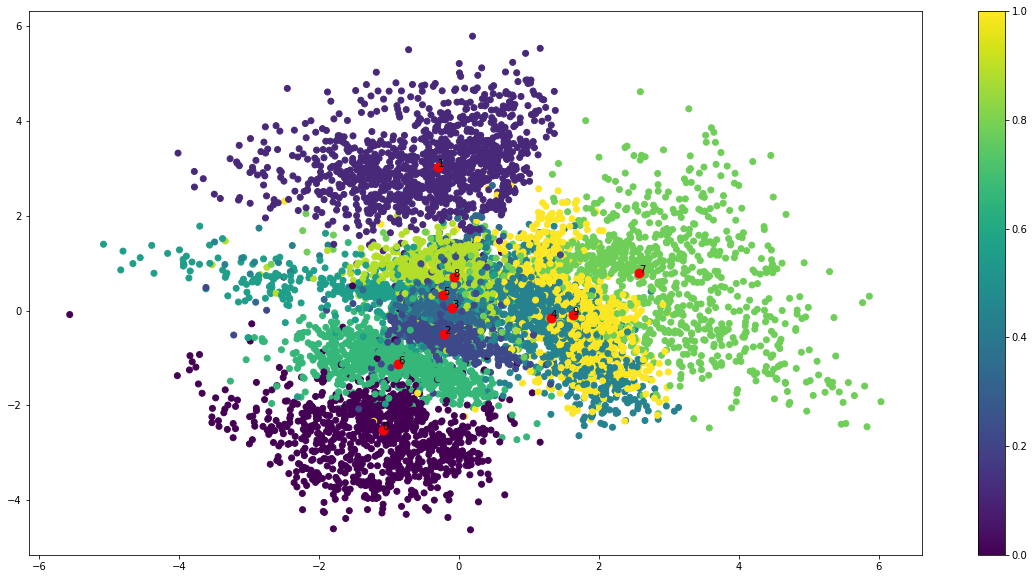

In [34]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.scatter(centroids.keys(), centroids.values(), color='red', s=80)
#plt.plot(fixed_t_x_vals, fixed_t_y_vals, '-D',color='cyan', markersize=10) # for linear interpolation
#plt.plot(slerped_result[:,0], slerped_result[:,1], '-D',markersize=10, color='fuchsia') # for spherical interpolation

for i, key in enumerate(centroids_keys):
    plt.annotate(i, (key, centroids_vals[i]))

plt.colorbar()
plt.show()

## GANs in general

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
from keras.models import Sequential
from keras.layers import Reshape, Flatten, LeakyReLU, BatchNormalization

In [ ]:
print(x_train.shape, y_train.shape)

In [ ]:
image_shape = (28, 28, 1)

In [ ]:
latent_space_dimensions = (100,)
latent_input = Input(shape=latent_space_dimensions)

In [ ]:
def build_discriminator():
    # Shape of the image which is in 1D - 784 pixels and in 2D it is 28 * 28 pixels
    model = Sequential()
    # Flatten the image into 1D from 2D image
    img = Input(shape=image_shape)
    flattened_image = Flatten(input_shape=image_shape)(img)
    # Add a fully connected layer with leaky relu
    first_fc = Dense(512)(flattened_image)
    first_act = LeakyReLU(alpha=0.2)(first_fc)
    # Add another fully connected layer
    second_fc = Dense(256)(first_act)
    second_act = LeakyReLU(alpha=0.2)(second_fc)
    outputs = Dense(1, activation='sigmoid')(second_act)
    
    return Model(img, outputs)

In [ ]:
def build_generator():
    # Dimensions of the latent space point
    model = Sequential()
    # Putting into the input in the first FC layer and upsample
    first_fc = Dense(256)(latent_input)
    first_act = LeakyReLU(alpha=0.2)(first_fc)
    first_bn = BatchNormalization(momentum=0.8)(first_act)
    # Putting in the second and third FC layer
    second_fc = Dense(512)(first_bn)
    second_act = LeakyReLU(alpha=0.2)(second_fc)
    second_bn = BatchNormalization(momentum=0.8)(second_act)

    third_fc = Dense(1024)(second_bn)
    third_act = LeakyReLU(alpha=0.2)(third_fc)
    third_bn = BatchNormalization(momentum=0.8)(third_act)
    
    # Since we normalized it between 0 and 1 at the start, we use the sigmoid activation function
    generated_image = Dense(x_train.shape[1] * x_train.shape[2], activation='sigmoid')(third_bn)
    reshaped_image = Reshape(image_shape)(generated_image)
    
    return Model(latent_input, reshaped_image)

In [ ]:
generator = build_generator()
reshaped_image = generator(latent_input)
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
discriminator = build_discriminator()
real_or_fake = discriminator(reshaped_image)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
discriminator.trainable = False

In [ ]:
gan_model = Model(latent_input, real_or_fake)
gan_model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
def summarise_performance(epoch):
    dimensions = 5
    g_number = 5
    
    latent_space_points = np.random.normal(0, 1, (dimensions * g_number, 100))
    gen_imgs = generator.predict(latent_space_points)

    fig, axs = plt.subplots(dimensions, g_number)
    cnt = 0
    for i in range(dimensions):
        for j in range(g_number):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/home/harshdeep/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
def train(epochs, batch_size=128, eval_time=100):
    train = np.expand_dims(x_train, axis=3)
    half_batch = int(batch_size / 2)

    for epoch in tqdm_notebook(range(epochs)):
        idx = np.random.randint(0, train.shape[0], half_batch)
        real_images = train[idx]

        noise = np.random.uniform(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = gan_model.train_on_batch(noise, valid_y)

        # Write the accuracy for every 50 steps and for 3000 steps save photos
        if epoch % 50 == 0:
            print('For DISCRIMINATOR epoch: {} - REAL loss is: {} -- FAKE loss is : {}'.format(
                epoch, d_loss_real, d_loss_fake))
            print('For GENERATOR epoch: {} loss is: {}'.format(epoch, g_loss))

        if ((epoch % eval_time == 0) or (epoch == (epochs - 1))):
            summarise_performance(epoch)


In [ ]:
# Train the model on 10000 epochs - could be changed with eval on ever 500 epochs
train(50000, batch_size=64, eval_time=3000)

## cGANs in general

## VAE-cGAN in general